In [1]:
#using TaylorSeries
include("UndrivenHelium.jl")
#include("Integ.jl")
using Plots, LaTeXStrings
# plotly()
pyplot(grid = :false, legend = :false, size=(600,600), color=:black, markersize = 0.3 )
const Z = 2.0
const order = 20
const t0 = 0.0
const t_max = 0.5 
const abs_tol = 1.0E-20
const steps = 500_000

500000

## Revisamos compatibilidad hamiltoniano vs ecs de movimiento

  3.403626 seconds (24.65 M allocations: 1.317 GiB, 14.93% gc time)



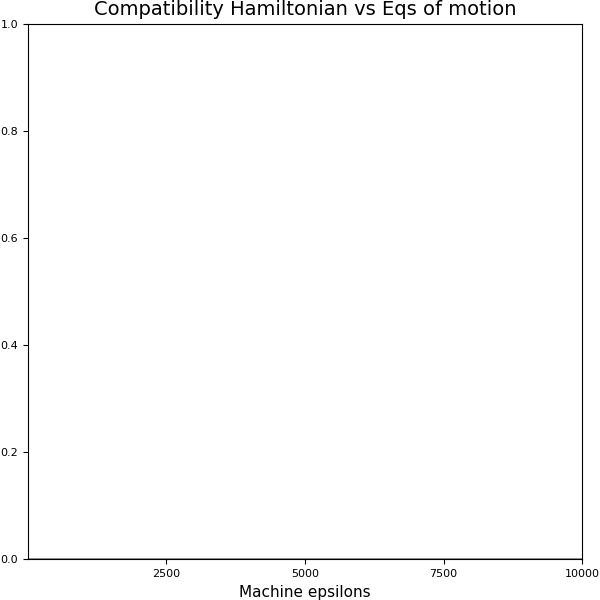

In [2]:
@time dnorm, als= errHam1D(10_000);
plot(eachindex(dnorm), dnorm, title = "Compatibility Hamiltonian vs Eqs of motion")
xaxis!("Machine epsilons")

# Incluimos funciones para obtener secciones de Poincaré

In [3]:
include("Integ.jl")

taylorintegps (generic function with 1 method)

In [4]:
c1 = condini1D(5.0, 0.0)

4-element Array{Float64,1}:
 2.23607
 0.0    
 0.0    
 4.0    

In [8]:
t1, x1 = taylorinteg(undrivenHelium1D!, c1, t0, 1.0, order, abs_tol, maxsteps=100)
@time t1, x1 = taylorinteg(undrivenHelium1D!, c1, t0, 15.0, order, abs_tol, maxsteps=10_000);

  0.220825 seconds (1.01 M allocations: 86.577 MiB, 70.46% gc time)


In [9]:
t2, x2 = taylorintegps(undrivenHelium1D!, c1, t0, 1.0, order, abs_tol, maxsteps=100)
@time t2, x2 = taylorintegps(undrivenHelium1D!, c1, t0, 15.0, order, abs_tol, maxsteps=10_000);

  0.087550 seconds (1.02 M allocations: 87.540 MiB, 27.70% gc time)


In [10]:
length(t1), length(t2)

(527, 546)

In [11]:
ene1 = zeros(t1)
ene2 = zeros(t2)
for j in eachindex(ene1)
    ene1[j] = abs(regHam1D(x1[j,:]))/eps()
end
for j in eachindex(ene2)
    ene2[j] = abs(regHam1D(x2[j,:]))/eps()
end


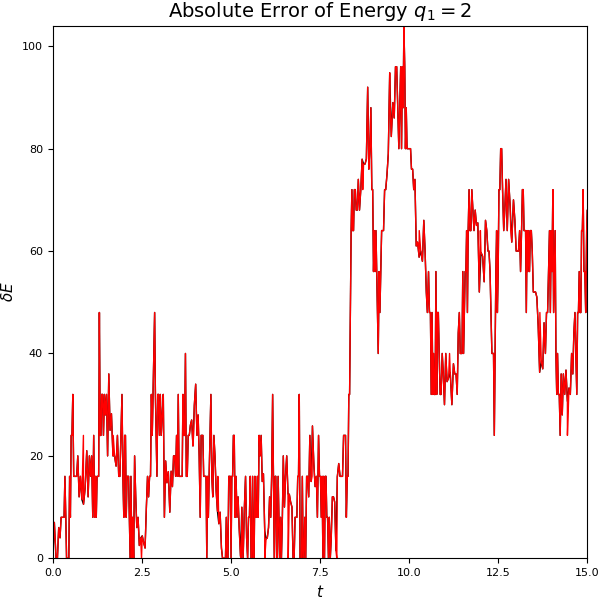

In [12]:
plot(t1, ene1, title =L"Absolute Error of Energy $q_1=2$", color = :black)
plot!(t2, ene2, title =L"Absolute Error of Energy $q_1=2$",color=:red, label=L"Cálculo con Sección de Poincaré")
xaxis!(L"t")
yaxis!(L"\delta E")



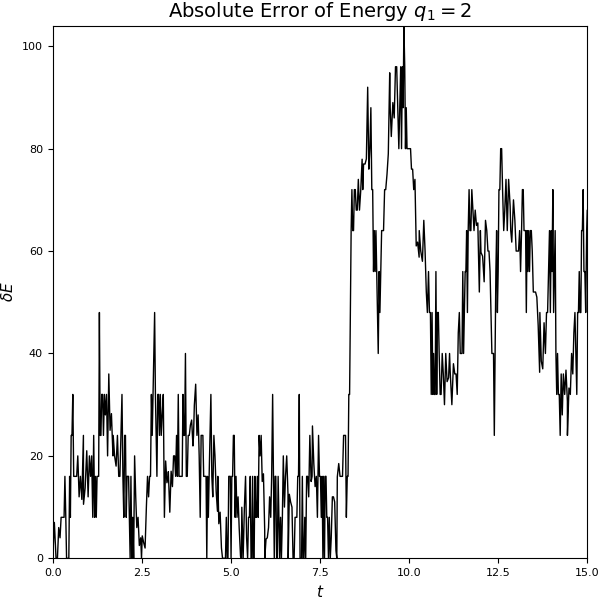

In [13]:
plot(t2, ene2, title =L"Absolute Error of Energy $q_1=2$")
xlabel!(L"t")
ylabel!(L"\delta E")

In [14]:
maximum(ene1)

104.0

# Implementamos funciones para obtener gráficas de las secciones de Poincaré

In [15]:
function psundriven(x10::Float64, px10::Float64; tol::Float64 = 1e-20, tmax = 100.0, maxsteps1 = 5_000 )
    c1 = condini1D(x10, px10)
    t, x, tp, xp = taylorintegps(undrivenHelium1D!, c1, t0, tmax, order, abs_tol; maxsteps = maxsteps1)
    
    return xp, t, x
end

psundriven (generic function with 1 method)

In [16]:
#Haremos malavares con metaprogramming para ver varias órbitas
nombret(n::Int) = Symbol( string("t", n) )
nombreps(n::Int) = Symbol( string("ps", n) )
nombreq(n::Int) = Symbol( string("q", n) )
nombrexs(n::Int) = Symbol( string("xs", n) )
nombrevxs(n::Int) = Symbol( string("vxs", n) )
nombreys(n::Int) = Symbol( string("ys", n) )
nombrevys(n::Int) = Symbol( string("vys", n) )

function orbits(nmin, rs = 2:10)
    N = length(rs)
    # Checo que `n` sea >= 1
    @assert N >= 0  

    for j = nmin:(N+nmin - 1)
        ex1 = quote 
            $(nombreps(j)), $(nombret(j)), $(nombreq(j))  = 
                psundriven(Float64($(rs[j])), 0.0; tmax = 100.0, maxsteps1 = 5_000 )
             end
        ex2 = quote 
            $(nombrexs(j)) = map(ks, $(nombreps(j))[:,1])
             end
        
        ex3 = quote 
                 $(nombrevxs(j)) =  
            Float64[ksv($(nombreps(j))[k,1], $(nombreps(j))[k, 3]) 
                 for k in eachindex($(nombreps(j))[:, 1])]
             end
        ex4 = quote 
            $(nombreys(j)) = map(ks, $(nombreps(j))[:,2])
             end
        
        ex5 = quote 
            $(nombrevys(j)) =  
            Float64[ksv($(nombreq(j))[k,2], $(nombreps(j))[k, 4]) 
                for k in eachindex($(nombreps(j))[:,1])]
             end
        eval(ex1)
        eval(ex2)
        eval(ex3)
        eval(ex4)
        eval(ex5)
    end
end

function plottingps(nmax,xmin::Float64=0.0, xmax::Float64=20.0, 
    ymin::Float64=-1.0, ymax::Float64=1.0)
    scatter(xs1, vxs1, label = L"q = 2", title = L"Poincaré Section $Z = 2$,  $r_{2_0} =0$")
    for j in 2:nmax
        ex = quote
            scatter!($(nombrexs(j)), $(nombrevxs(j)))
        end
        eval(ex)
    end
    xaxis!([0,20])
    xlabel!(L"x")
    ylabel!(L"p_x")
    yaxis!([ymin, ymax])
    xaxis!([xmin, xmax])
end

function ksv(Q, P)
    v₁ = P/2Q
    return v₁
end
ks(Q) = Q^2

ks (generic function with 1 method)

In [17]:
@time orbits(1,2:0.1:10)
NM = length(2:0.1:10)

 51.220628 seconds (601.22 M allocations: 49.804 GiB, 25.70% gc time)


81

  0.707246 seconds (386.97 k allocations: 19.340 MiB, 1.36% gc time)



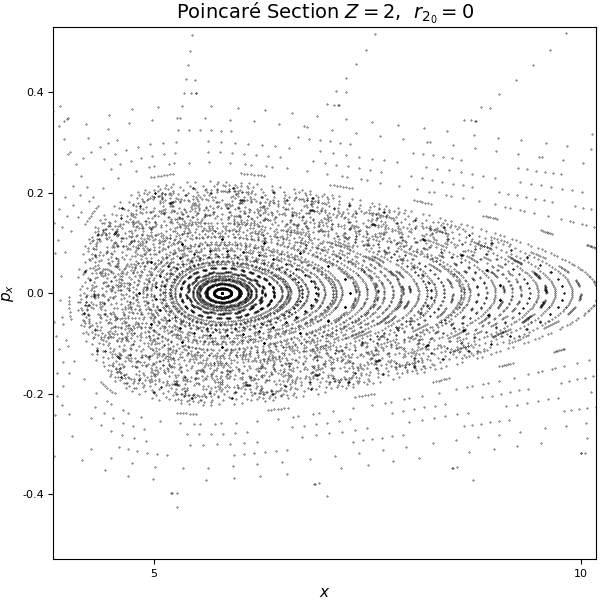

In [18]:
@time plottingps(NM, 4.0, 10., -.5, .5)
#@time plottingps(NM, 0., 4., -0.5, 0.5)

In [19]:
tvSv = Array{Float64,1}[]
xvSv = Array{Float64,2}[]
gvSv = Array{Float64,1}[]
x0 = Float64[6.5, 0.0]

nconds2 = 100 #number of initial conditions
@time for i in 1:nconds2
    rand1 = rand(); rand2 = rand()
    x_ini = condini1D((x0 + 0.00005*[sqrt(rand1)*cos(2pi*rand2),sqrt(rand1)*sin(2pi*rand2)])...)
    xp, t, x = psundriven(x_ini[1], x_ini[2]; tmax = 30.0, maxsteps1 = 5_000 )
    push!(xvSv, vcat(x_ini', xp))
end

 70.884915 seconds (879.82 M allocations: 72.907 GiB, 29.26% gc time)


Maximum number of integration steps reached; exiting.



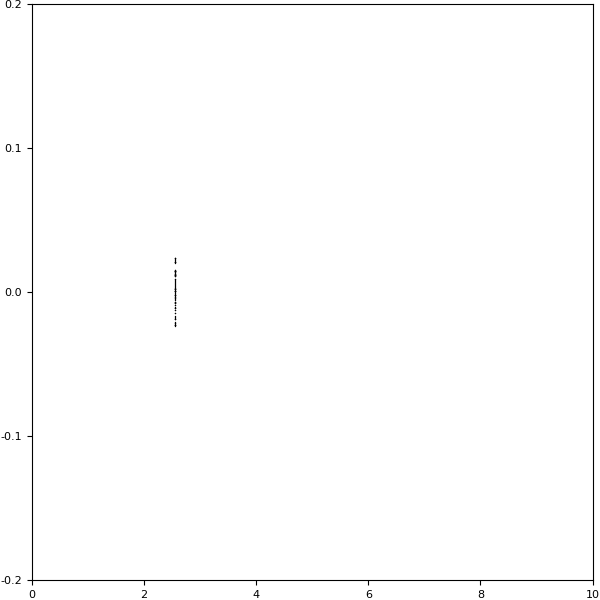

In [29]:
i = 2
scatter(map(x->x[1,1], xvSv), map(x->x[1,3], xvSv), label="$(i-1)-th iterate", m=(1,stroke(0)))
xlims!(0.0,10.0)
    ylims!(-0.2,0.2)

In [24]:
pyplot()
poincareani5 = @animate for i=1:21
    scatter(map(x->x[i,1], xvSv), map(x->x[i,3], xvSv), label="$(i-1)-th iterate", m=(1,stroke(0)))
    xlims!(0.0,10.0)
    ylims!(-0.2,0.2)
    xlabel!("x")
    ylabel!("pₓ")
    title!("Undriven Helium Poincaré map near a period 5 orbit")
end
gif(poincareani5, "./henonheilespoincaremap5.gif", fps = 2)

INFO: Saved animation to /home/daniel/Documents/2017-2/Tesis/UndrivenHelium/TaylorIntegration/henonheilespoincaremap5.gif


Plots.AnimatedGif("/home/daniel/Documents/2017-2/Tesis/UndrivenHelium/TaylorIntegration/henonheilespoincaremap5.gif")

In [ ]:
@time plottingps(NM, 5.8, 5.8008, -0.00005, 0.00005)

In [ ]:
@time pd, td, xd = psundriven(5.8004, 0.0; tmax = 2_000.0, maxsteps1 = 10_000)

In [ ]:
length(td), length(pd)

In [ ]:
psdx = map(ks, pd[:,1])
ll = length(psdx)
psdvx = Float64[ksv(pd[j,1],pd[j,3]) for j in 1:ll]
scatter(psdx, psdx, label = L"q = 5.80004", title = L"Poincaré Section $Z = 2$,  $r_{2_0} =0$")
xlabel!(L"x")
ylabel!(L"p_x")

In [ ]:
pd

La aproximación a ojo es mala, por ello, se usará un Método de Newton modificado para calcular el ciclo estable, usando jet transport (necesitamos una precisión del orden $\sim10^{-14}$)